The code is designed to implement Ancilla Driven Blind Quantum Computation (ADBQC), leveraging Bell pairs for their resilience to channel loss. It is structured to generate the HR_Z(ϕ) operator, where ϕ is designated rotation angle around z-axis.   
We encrypt ϕ as ϕ_.
\begin{equation}
       \phi\_ = -\phi + (-1)^{s_1} \left( \frac{k}{4} + s_0 \right)\pi + r\pi.
\end{equation}

In [14]:
from mpmath.functions.zetazeros import count_to
from qiskit import transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.pulse import measure
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSampler
from qiskit.providers.fake_provider import GenericBackendV2
import numpy as np
from scipy.signal import ellip
from scipy.stats import kstwo
import random
import matplotlib.pyplot as plt

In [18]:
# Initialize lists to store k and r values
k_values = []
r_values = []
results = []
# Number of runs
num_runs = 10000

In [19]:
class QuantumCircuitWithRandomKAndR(QuantumCircuit):
    def __init__(self, num_qubits, num_clbits):
        super().__init__(num_qubits, num_clbits)
        self.k = np.random.choice(np.arange(8))  # Uniformly select k from {0, 1, 2, 3, 4, 5, 6, 7}
        self.r = np.random.choice(np.arange(2))  # Uniformly select r from {0, 1}
        
        k_values.append(self.k)
        r_values.append(self.r)
        theta0 = self.k * np.pi / 4
        phi = 1.16

        (q0, q1, q2) = self.qubits
        (c0, c1, c2) = self.clbits

        self.h(q1)
        self.cx(q1, q2)
        self.rz(theta0, q2)
        self.measure(q2, c0)
        self.barrier()

        self.cx(q0, q1)
        self.h(q0)
        self.measure(q1, c1)
        self.barrier()

        self.reset(q1)
        self.cx(q0, q1)
        self.h(q0)
        self.measure(q1, c1)
        self.barrier()

        if (c1, 0):
            c1_ = 0
        else:
            c1_ = 1

        if (c2, 0):
            c2_ = 0
        else:
            c2_ = 1

        phi_ = -phi + (-1) ** c1_ * (self.k / 4 + c2_) * np.pi + self.r * np.pi

        self.reset(q1)
        self.h(q1)
        self.cx(q0, q1)
        self.h(q0)
        self.rz(-phi_, q1)
        self.h(q1)
        self.measure(q1, c1)
        self.barrier()

        self.rz(-phi, q0)
        self.h(q0)

        with self.if_test((c1, 0)) as else_:
            if self.r == 1:
                self.x(q0)
        with else_:
            if self.r == 0:
                self.x(q0)

        self.measure(q0, c0)

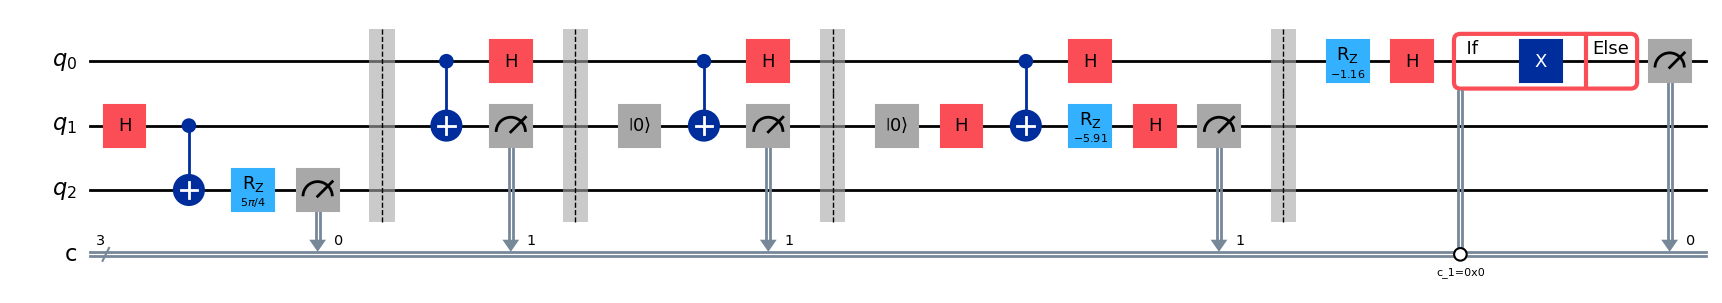

In [6]:
# circuit = QuantumCircuitWithRandomKAndR(3, 3)
# circuit.draw('mpl')

In [20]:
# Create an instance of the QuantumCircuitWithRandomKAndR class
num_qubits = 3
num_clbits = 3
shots = 1
simulator = AerSimulator()
for i in range(num_runs):
    qc = QuantumCircuitWithRandomKAndR(num_qubits, num_clbits)
    simulator = AerSimulator()
    result = simulator.run(qc, shots=shots, memory=True).result()
    results.append(result)



In [21]:
print(len(r_values))  
print(len(k_values))

10000
10000


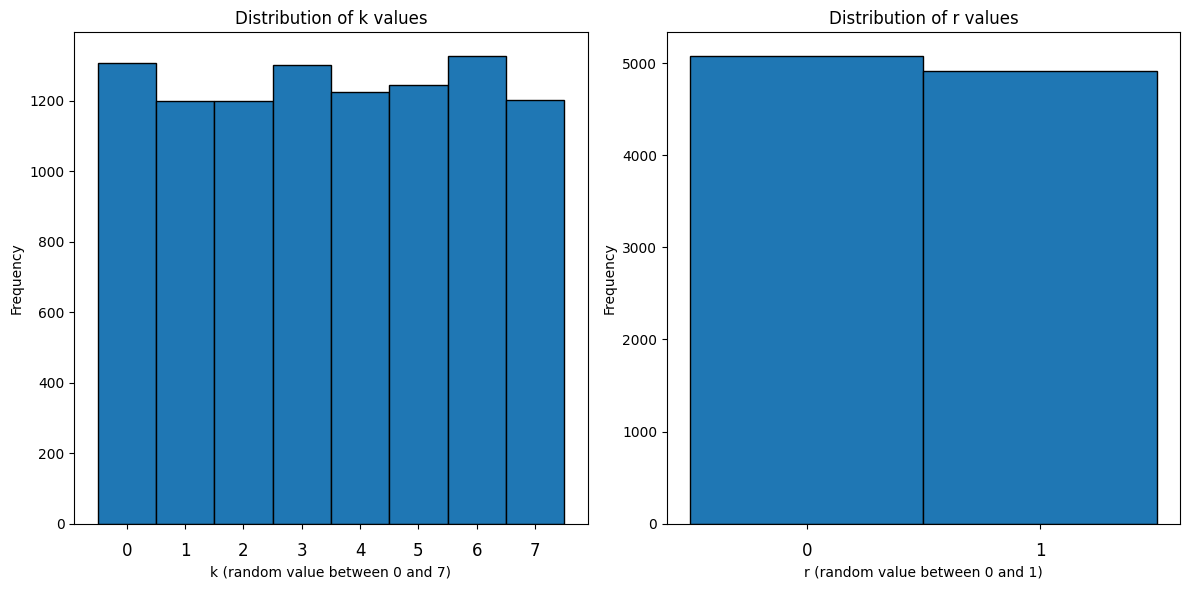

In [22]:
# Plot the histogram of k and r
plt.figure(figsize=(12, 6))

# Plot histogram for k values
plt.subplot(1, 2, 1)
plt.hist(k_values, bins=np.arange(9) - 0.5, edgecolor='black')
plt.xticks(np.arange(8), labels=np.arange(8), fontsize=12)  # Set the font size for the tick labels
plt.xlabel('k (random value between 0 and 7)')
plt.ylabel('Frequency')
plt.title('Distribution of k values')
plt.gca().tick_params(axis='x', pad=10)  # Add padding between the ticks and labels

# Plot histogram for r values
plt.subplot(1, 2, 2)
plt.hist(r_values, bins=np.arange(3) - 0.5, edgecolor='black')
plt.xticks(np.arange(2), labels=np.arange(2), fontsize=12)  # Set the font size for the tick labels
plt.xlabel('r (random value between 0 and 1)')
plt.ylabel('Frequency')
plt.title('Distribution of r values')
plt.gca().tick_params(axis='x', pad=10)  # Add padding between the ticks and labels

plt.tight_layout()
plt.show()


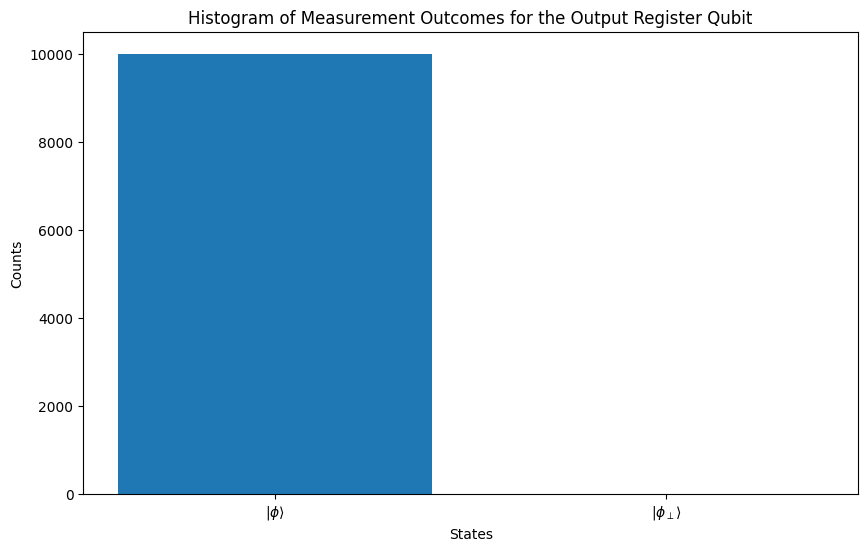

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a dictionary to store the filtered counts for c0
filtered_counts = {'0': 0, '1': 0}

# Iterate through the results to accumulate the counts
for result in results:
    counts = result.get_counts()
    for outcome, count in counts.items():
        # The outcome string is in the form 'c0c1c2', so we take the first character to get c0
        c0 = outcome[0]
        # Increment the corresponding count in the filtered_counts dictionary
        filtered_counts[c0] += count

# Create a dictionary to map the original labels to the new labels
label_map = {'0': r'$|\phi\rangle$', '1': r'$|\phi_{\perp}\rangle$'}

# Prepare data for plotting
labels = [label_map[key] for key in filtered_counts.keys()]
values = [filtered_counts[key] for key in filtered_counts.keys()]

# Plot the 2D histogram using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel('States')
plt.ylabel('Counts')
plt.title('Histogram of Measurement Outcomes for the Output Register Qubit')
plt.show()